In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Itt most beállítjuk az adatbázist

In [3]:
import pymssql
def runsql(sql):
    conn = pymssql.connect("future1", "", "", "sunspot")
    cursor = conn.cursor()
    cursor.execute(sql)
    arr = np.array(cursor.fetchall())
    conn.commit()
    return arr

Lekérünk egy foltcsoportot

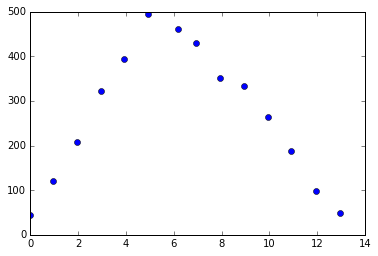

In [4]:
a = runsql("EXEC [VO\zsg].GetGroupFull_GPR 19454")
jd = double(a[:,2])
jd = jd - jd[0]
ar = double(a[:,3])
plot(jd,ar,'o')

## Skew-normal eloszlás

In [5]:
import scipy.special

def skew(x,a=1,m=0,s=1,n=0):
    return 2 * a*exp(-(x-m)**2/(2*s**2)) * 1.0/2.0 * (1 + scipy.special.erf(n * (x - m) / (s * sqrt(2))))

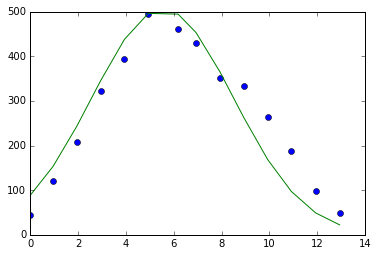

In [6]:
p0 = [500, 6, 3, -0.2]
ff = skew(jd, p0[0], p0[1], p0[2], p0[3])
plot(jd,ar,'o')
plot(jd, ff, '-')

## Optimalizálás maximum-likelihood módszerrel

In [7]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(skew, jd, ar, p0 = p0)
print(popt)

[ 320.29233127    2.99090902    4.89361691    2.04543805]


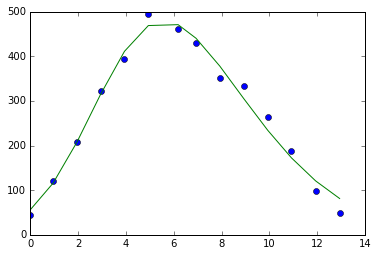

In [8]:
ff = skew(jd, popt[0], popt[1], popt[2], popt[3])
plot(jd,ar,'o')
plot(jd, ff, '-')

## Optimalizálás naív MCMC-vel (ami nem működik)

In [117]:
N = 5000
pmcmc = np.ndarray([N,4])
sqmcmc = np.ndarray(N)

pp = [500, 5, 1, 0]
i = 0

while i < N:    
    ff = skew(jd, pp[0], pp[1], pp[2], pp[3])
    sq = np.sum((ff - ar)**2)
    
    accept = False
    
    if (i == 0):
        accept = True
        
    if (not accept and sq < sqmcmc[i - 1]):
        accept = True
        
    # exp(-chi2) valoszinuseggel elfogadjuk
    if (not accept):
        kT = 50000.0
        q = np.exp((sqmcmc[i - 1] - sq) / kT)
        #print(sqmcmc[i - 1] - sq)
        #print(q)
        #break
        if (random.random() < q):
            accept = True
    
    if (accept):
        pmcmc[i] = pp
        sqmcmc[i] = sq
        i = i + 1
        
    # Most lötyögtetjük

    pp[0] += 10.0 * (random.random() - 0.5)
    pp[1] += 1.0 * (random.random() - 0.5)
    pp[2] += 0.1 * (random.random() - 0.5)
    pp[3] += 0.01 * (random.random() - 0.5)

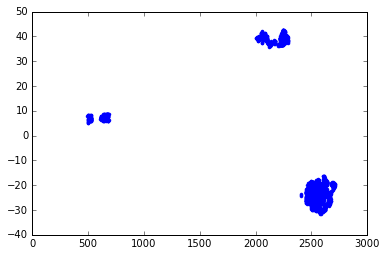

In [118]:
plot(pmcmc[:,0], pmcmc[:,1], '.')

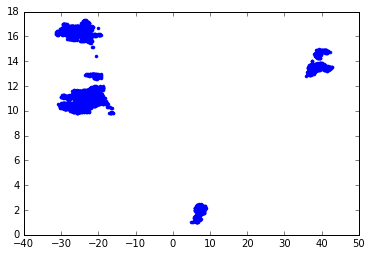

In [119]:
plot(pmcmc[:,1], pmcmc[:,2], '.')

[[  6.12947011e+02   6.49295105e+00   2.44315230e+00  -8.86449607e-02]]


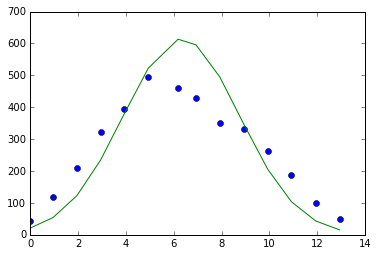

In [120]:
mn = sqmcmc.min()
idx = np.where(sqmcmc == mn)[0]
print(pmcmc[idx])

pp = np.squeeze(pmcmc[idx,:])
ff = skew(jd, pp[0], pp[1], pp[2], pp[3])
plot(jd,ar,'o')
plot(jd, ff, '-')

# Innen jön a működő pyMC-s MCMC

## Megkonstruáljuk a modelt

In [222]:
from pymc import MCMC, database, Matplot, graph

def model(x, f): 
    amp = pymc.Uniform('amp', 0, 1000, value = 500)
    mean = pymc.Uniform('mean', 0, 15, value = 7.5)
    sigma = pymc.Uniform('sigma', 0, 10, value = 5.0)
    n = pymc.Uniform('n', -4, 4, value = 0.0)

    @pymc.deterministic(plot=True)
    def skew(x=x,a=amp,m=mean,s=sigma,n=n):
        return 2 * a*exp(-(x-m)**2/(2*s**2)) * 1.0/2.0 * (1 + scipy.special.erf(n * (x - m) / (s * sqrt(2))))
    
    y = pymc.Normal('y', mu=skew, tau=0.01, value=f, observed=True)
    
    return locals()

## Most futtatjuk le a modelt

In [223]:
MDL = pymc.MCMC(model(jd,ar))
MDL.sample(iter = 100000, burn = 20000, thin = 100)

 [-----------------100%-----------------] 100000 of 100000 complete in 24.1 sec

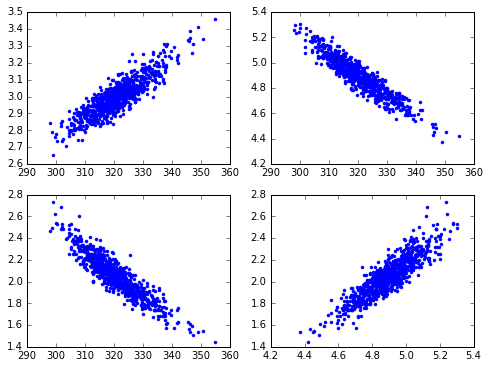

In [224]:
a = MDL.trace('amp')[:]
m = MDL.trace('mean')[:]
s = MDL.trace('sigma')[:]
n = MDL.trace('n')[:]

figure(figsize=(8, 6))

subplot(221)
plot(a, m, '.')

subplot(222)
plot(a, s, '.')

subplot(223)
plot(a, n, '.')

subplot(224)
plot(s, n, '.')

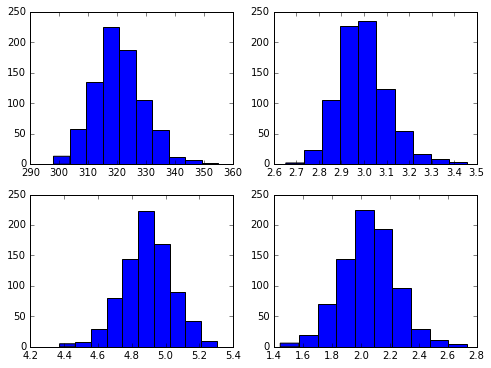

In [225]:
figure(figsize=(8, 6))

subplot(221)
_ = hist(a)

subplot(222)
_ = hist(m)

subplot(223)
_ = hist(s)

subplot(224)
_ = hist(n)

## Most felplotoljuk az eredményeket

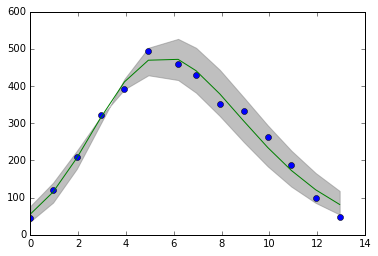

In [229]:
aa = MDL.stats()['amp']['mean']
mm = MDL.stats()['mean']['mean']
ss = MDL.stats()['sigma']['mean']
nn = MDL.stats()['n']['mean']

aa_min = MDL.stats()['amp']['quantiles'][2.5]
mm_min = MDL.stats()['mean']['quantiles'][2.5]
ss_min = MDL.stats()['sigma']['quantiles'][2.5]
nn_min = MDL.stats()['n']['quantiles'][2.5]

aa_max = MDL.stats()['amp']['quantiles'][97.5]
mm_max = MDL.stats()['mean']['quantiles'][97.5]
ss_max = MDL.stats()['sigma']['quantiles'][97.5]
nn_max = MDL.stats()['n']['quantiles'][97.5]

ff = skew(jd, aa, mm, ss, nn)
ff_min = skew(jd, aa_min, mm_min, ss_min, nn_min)
ff_max = skew(jd, aa_max, mm_max, ss_max, nn_max)
fill_between(jd, ff_min, ff_max, color='0.5', alpha=0.5)
plot(jd,ar,'o')
plot(jd, ff, '-')